<a href="https://colab.research.google.com/github/monitamitra/JPMorgan-Chase_StockPrediction/blob/main/JPM_Stock_Prediction_LTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Packages/Modules**

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from google.colab import files

# **Load the Dataset**

In [ ]:
training_data = pd.read_csv("/content/drive/MyDrive/JPM_Training.csv")
training_data

# **Transform Data**

**Change Type of Training Set**

In [ ]:
# don't care about volume (remove last column from dataframe)
# converted to numpy array as keras only accepts numpy arrays
training_data = training_data.iloc[:, 1].values

**Feature Scaling the Dataset**

In [ ]:
# normalization
# makes each feature on a similar scale
scaler = MinMaxScaler() # => scales every observation to be between 0 and 1
training_data = scaler.fit_transform(training_data.reshape(-1, 1)) # => actually reshapes the data

# **Setting the Number of Timesteps**

**Initialize Data Structures to Hold Observations**

In [ ]:
# timesteps = how many previous observations should be considered when model makes a prediction on the current observation
# set to 40 -> 20 stock days in a month so will use previous 2 months of stock data points to predict current stock

x_training_data = [] # => contains last 40 stock price observations in dataset
y_training_data = [] # => contains stock price for next trading day (data point that neural network is trying to predict)

# loops from index 40 to end of data
for i in range(40, len(training_data)):
    # appends the 40 preceding stock prices
    x_training_data.append(training_data[i-40:i, 0])
    # appends next days stock price
    y_training_data.append(training_data[i, 0])



**Transform Datasets into Numpy Arrays**

In [ ]:
# keras only accepts numpy arrays so need to transform datasets into numpy arrays
x_training_data = np.array(x_training_data)
y_training_data = np.array(y_training_data)

**Transform Preceeding Observations Dataset**

In [ ]:
# tensorflow accepts data in a very specific format
x_training_data = np.reshape(x_training_data, (x_training_data.shape[0], x_training_data.shape[1], 1))

# **Building the Neural Network**

In [ ]:
rnn = Sequential() # => adds sequential layers over time to network

**Adding the First LTSM Layer**

In [ ]:
# units => number of neurons in network, increases dimensionality
# return_sequences => boolean for wheather more layers are going to be added
# input_shape => number of timesteps and number of predictors in training data (only 1 predictor => stock price)
rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))

**Dropout Regularization**

In [ ]:
# avoids overfitting when training neural networks
# randomly excludes certain layer dropouts during the training stage
rnn.add(Dropout(0.2)) # => convention dropout rate = 20%

**Adding More Layers & Dropout**

In [ ]:
# Layer 2
rnn.add(LSTM(units = 45, return_sequences = True))
rnn.add(Dropout(0.2))

# Layer 3
rnn.add(LSTM(units = 45, return_sequences = True))
rnn.add(Dropout(0.2))

# Layer 4
rnn.add(LSTM(units = 45))
rnn.add(Dropout(0.2))

**Adding Output Layer**

In [ ]:
# only want to output the next day's stock price (single value) => units = 1
rnn.add(Dense(units = 1))

# **Compiling the Model**

In [ ]:
# using continuous variable
rnn.compile(optimizer = "adam", loss = "mean_squared_error")

# **Fitting the Model on the Training Set**

In [ ]:
# epochs => number of iterations the network should be trained on
# batch size => size of batches that network trains during each epoch
rnn.fit(x_training_data, y_training_data, epochs = 100, batch_size = 32)

# **Preprocessing Data for Predictions**

**Transforming the Test Dataset**

In [30]:
test_data = pd.read_csv("/content/drive/MyDrive/JPM_Testing.csv")
test_data = test_data.iloc[:, 1].values

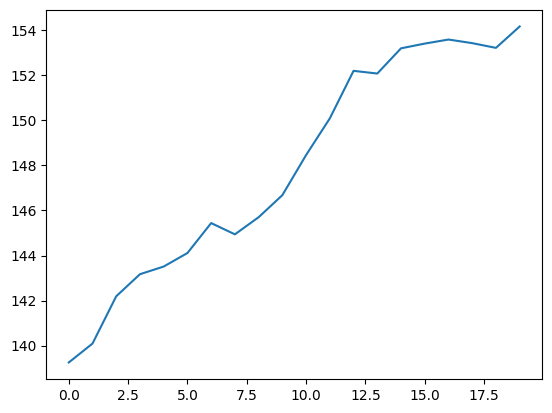

In [31]:
plt.plot(test_data)

In [33]:
# need original data because data has already been transformed
# to make predictions, 40 preceeding stock data points could be in training set and/or testing set
unscaled_x_training_data = pd.read_csv("/content/drive/MyDrive/JPM_Training.csv")
unscaled_test_data = pd.read_csv("/content/drive/MyDrive/JPM_Testing.csv")
all_data = pd.concat((unscaled_x_training_data['Open'], unscaled_test_data['Open']), axis = 0)

In [34]:
# need to create an array of all stock prices from November 2023 and 40 trading days prior
x_test_data = all_data[len(all_data) - len(test_data) - 40:].values
x_test_data = np.reshape(x_test_data, (-1, 1))

**Scaling the Test Dataset**

In [35]:
# want to transform test data according to fit generated from entire training data set
# ensures transformation applied to test data is similar to training data => necessary for predictions to be accurate
x_test_data = scaler.transform(x_test_data)

**Grouping of Test Dataset**

In [36]:
# group arrays to where each entry = date in November and contains stock prices of 40 previous trading days
final_x_test_data = []
for i in range(40, len(x_test_data)):
    final_x_test_data.append(x_test_data[i-40:i, 0])

final_x_test_data = np.array(final_x_test_data)

# reshape test data to tensorflow's liking
final_x_test_data = np.reshape(final_x_test_data, (final_x_test_data.shape[0], final_x_test_data.shape[1], 1))

# **Making Predictions With the Model**

**Scaled Version**

1/1 [==============================] - 2s 2s/step


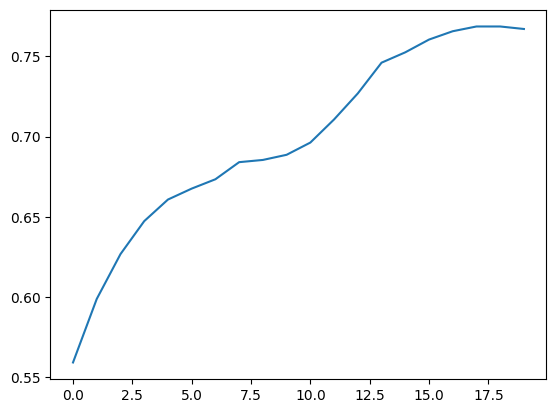

In [37]:
predictions = rnn.predict(final_x_test_data)
plt.clf() # => clears canvas
plt.plot(predictions)

**Actual (Unscaled Version)**

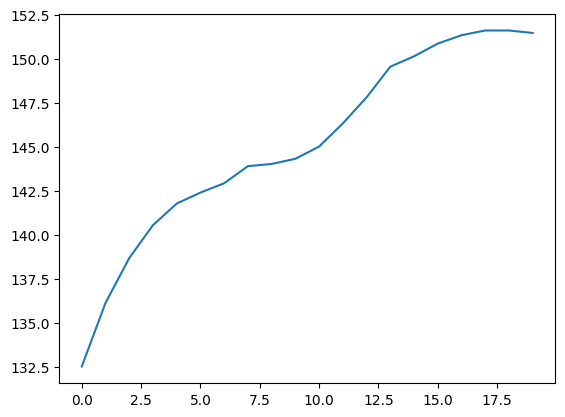

In [38]:
unscaled_predictions = scaler.inverse_transform(predictions)
plt.clf()
plt.plot(unscaled_predictions)

**Comparison**

Text(0.5, 1.0, 'JP Morgan & Chase Co. Stock Price Predictions')

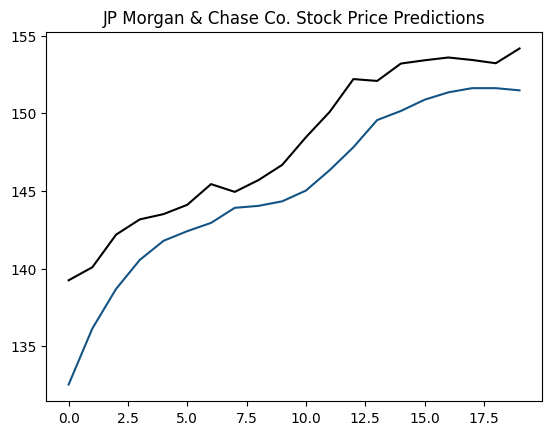

In [39]:
plt.plot(unscaled_predictions, color = '#135485', label = "Predictions")
plt.plot(test_data, color = 'black', label = "Real Data")
plt.title('JP Morgan & Chase Co. Stock Price Predictions')

# **Save the Model**

In [52]:
rnn.save("Stock_Pred_LSTM.h5")
files.download("Stock_Pred_LSTM.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>